In [0]:
import pandas as pd
import numpy as np
from tensorflow.python.ops import nn_ops, gen_nn_ops
import tensorflow as tf

/home/gin908/paper_ready/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gin908/paper_ready/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gin908/paper_ready/py_36_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gin908/paper_ready/py_36_env/lib/python3

In [0]:
class CNN_MC_dropout:
    def __init__(self, std=0.01, batch_size=64,width=500, height =1, input_channel=3, nb_classes=2, l_rate =1e-6,reuse = False):
        self.std=std
        self.batch_size=batch_size
        self.height = height
        self.width = width
        self.input_channel = input_channel
        self.l_rate = l_rate
        
        self.nb_classes = nb_classes

        with tf.name_scope('Classifier'):
            self.y = tf.placeholder(tf.float32, [None, self.nb_classes], name='y')
            self.x = tf.placeholder(tf.float32, [None, self.height,self.width,self.input_channel], name='x')
            self.keep_prob = tf.placeholder(tf.float32)
            self.is_dropout = tf.placeholder(tf.bool)
        
        # keep prob가 1보다 작으면, 드랍아웃을 한다는 의미
        #self.dropout_bool = True#tf.cond(self.keep_prob < 1.0, lambda: tf.constant(True), lambda: tf.constant(False))
        
        self.logits = self.build_model()

        # Define loss and optimizer, minimize the squared error
        self.cross_entropy =  tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=self.logits)
        self.cost =tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(self.l_rate).minimize(self.cost)

        self.correct_pred = tf.equal(tf.round(self.prediction),self.y)
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

        init = tf.global_variables_initializer()

        # Launch the session
        self.session_conf = tf.ConfigProto()
        self.session_conf.gpu_options.allow_growth = True
        self.sess = tf.InteractiveSession(config=self.session_conf)
        self.sess.run(init)

        self.saver = tf.train.Saver(max_to_keep=None)

    def build_model(self):
        with tf.variable_scope('layer0'):
            #b, h, w, c
            self.input = self.x
        # Convolutional Layer #1 and Pooling Layer #1
        with tf.variable_scope('layer1'):
            self.conv1 = tf.layers.conv2d(self.input, 128, [8,1], padding='SAME')
            self.batch1 = tf.layers.batch_normalization(self.conv1)
            self.relu1 = tf.nn.relu(self.batch1)
            self.dropout1 = tf.nn.dropout(self.relu1, self.keep_prob)

        # Convolutional Layer #1 and Pooling Layer #2
        with tf.variable_scope('layer2'):
            self.conv2 = tf.layers.conv2d(self.dropout1, 256, [5,1], padding='SAME')
            self.batch2 = tf.layers.batch_normalization(self.conv2)
            self.relu2 = tf.nn.relu(self.batch2)
            self.dropout2 = tf.nn.dropout(self.relu2, self.keep_prob)

        # Convolutional Layer #1 and Pooling Layer #3
        with tf.variable_scope('layer3'):
            self.conv3 = tf.layers.conv2d(self.dropout2, 128, [3,1], padding='SAME')
            self.batch3 = tf.layers.batch_normalization(self.conv3)
            self.relu3 = tf.nn.relu(self.batch3)

        # Dense Layer with Relu
        with tf.variable_scope('layer4'):
            #Global Average Pooling
            self.GAP = tf.reduce_mean(self.relu3, axis=[1,2])# b,h,w,c
            self.logits = tf.layers.dense(self.GAP,self.nb_classes)
            self.prediction = tf.nn.softmax(self.logits)
            
        return self.logits


    def train(self, data, target, keep_prob,is_dropout):
        opt, cost ,acc = self.sess.run((self.optimizer, self.cost, self.accuracy ), 
                             feed_dict={self.y: target,
                                        self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return cost,acc

    def test(self, data, target, keep_prob,is_dropout):
        cost,acc = self.sess.run((self.cost,self.accuracy),
                             feed_dict={self.y: target,
                                        self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return cost,acc

    def get_last_conv_output(self, data, keep_prob,is_dropout):
        relu3 =  self.sess.run((self.relu3), 
                             feed_dict={self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return relu3
    
    def predict(self, data, keep_prob,is_dropout):

        prediction =  self.sess.run((self.prediction), 
                             feed_dict={self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return prediction

    def save(self, save_path='./model.ckpt'):
        saved_path = self.saver.save(self.sess, save_path)
        print("Model saved in file: %s"%saved_path)

    def load(self, load_path = './model.ckpt'):
        self.saver.restore(self.sess, load_path)
        print("Model restored")

    def terminate(self):
        self.sess.close()
        tf.reset_default_graph() 

# 1. Data Load
### 전처리 width, height, input_channel 정의

In [0]:
import os

In [0]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter = ',')
    Y = data[:,0]
    X = data[:,1:]
    return X, Y

In [0]:
data_path ="/home/gin908/data/UCR_TS_Archive_2015"
fname = 'yoga'

In [0]:
full_data_path = os.path.join(data_path,fname)
if os.path.exists(full_data_path):
    x_train, y_train = readucr(full_data_path+'/'+fname+'_TRAIN')
    x_test, y_test = readucr(full_data_path+'/'+fname+'_TEST')
    nb_classes = len(np.unique(y_test))
    batch_size = min(int(x_train.shape[0]/10), 16)
    print ("batch size:{}".format(batch_size))

batch size:16


In [0]:
hot_encoded_y_train = np.asarray(pd.get_dummies(np.asarray(y_train)))
hot_encoded_y_test = np.asarray(pd.get_dummies(np.asarray(y_test)))

In [0]:
trainX = x_train[:, np.newaxis, :, np.newaxis]
trainY = hot_encoded_y_train

validX =x_test[:len(x_test)//2, np.newaxis, :, np.newaxis]
validY= hot_encoded_y_test[:len(x_test)//2]

testX = x_test[len(x_test)//2:, np.newaxis, :, np.newaxis]
testY = hot_encoded_y_test[len(x_test)//2:]

print ("trainX shape:{}".format(trainX.shape))
print ("trainY shape:{}".format(trainY.shape))
print ("validX shape:{}".format(validX.shape))
print ("validY shape:{}".format(validY.shape))
print ("testY shape:{}".format(testY.shape))
print ("testX shape:{}".format(testX.shape))
print ("testY shape:{}".format(testY.shape))

trainX shape:(300, 1, 426, 1)
trainY shape:(300, 2)
validX shape:(1500, 1, 426, 1)
validY shape:(1500, 2)
testY shape:(1500, 2)
testX shape:(1500, 1, 426, 1)
testY shape:(1500, 2)


In [0]:
height = trainX.shape[1]
width = trainX.shape[2]
input_channel = trainX.shape[3]

# 2. Training condition 정의

In [0]:
t_loss=[]
t_acc=[]

v_loss=[]
v_acc=[]

val_freq = 1
save_freq = 1
num_epochs= 100


std= 0.01
l_rate = 1e-3

In [0]:
train_history = pd.DataFrame(index=np.arange(0, num_epochs), columns=['epoch', 'loss', 'acc','timestamp'])
valid_history = pd.DataFrame(index=np.arange(0, num_epochs/val_freq),columns=['epoch', 'loss', 'acc','timestamp'])

# 3. model structure 정의

In [0]:
if 'MC_dropout_model' in globals():
    MC_dropout_model.terminate()
    
MC_dropout_model =CNN_MC_dropout(height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
                                 std=std,batch_size=batch_size,l_rate=l_rate)

In [0]:
print (MC_dropout_model.input)
print ('[layer1] - MC dropout')
print (MC_dropout_model.conv1)
print (MC_dropout_model.batch1)
print (MC_dropout_model.relu1)
print (MC_dropout_model.dropout1)
print ('[layer2] - MC dropout')
print (MC_dropout_model.conv2)
print (MC_dropout_model.batch2)
print (MC_dropout_model.relu2)
print (MC_dropout_model.dropout2)
print ('[layer3]')
print (MC_dropout_model.conv3)
print (MC_dropout_model.batch3)
print (MC_dropout_model.relu3)

print ('[layer4]')
print (MC_dropout_model.GAP)
print (MC_dropout_model.logits)

Tensor("Classifier/x:0", shape=(?, 1, 426, 1), dtype=float32)
[layer1] - MC dropout
Tensor("layer1/conv2d/BiasAdd:0", shape=(?, 1, 426, 128), dtype=float32)
Tensor("layer1/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 426, 128), dtype=float32)
Tensor("layer1/Relu:0", shape=(?, 1, 426, 128), dtype=float32)
Tensor("layer1/dropout/mul:0", shape=(?, 1, 426, 128), dtype=float32)
[layer2] - MC dropout
Tensor("layer2/conv2d/BiasAdd:0", shape=(?, 1, 426, 256), dtype=float32)
Tensor("layer2/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 426, 256), dtype=float32)
Tensor("layer2/Relu:0", shape=(?, 1, 426, 256), dtype=float32)
Tensor("layer2/dropout/mul:0", shape=(?, 1, 426, 256), dtype=float32)
[layer3]
Tensor("layer3/conv2d/BiasAdd:0", shape=(?, 1, 426, 128), dtype=float32)
Tensor("layer3/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 426, 128), dtype=float32)
Tensor("layer3/Relu:0", shape=(?, 1, 426, 128), dtype=float32)
[layer4]
Tensor("layer4/Mean:0", shape=(?, 128), dtype=flo

# 4. Training

In [0]:
import time

In [0]:
save_path = '/data2/gin/savedmodel'
model_name = 'ICML(UCR-'+fname+')_CNN_MCdropout_'+str(l_rate)+'_'+str(batch_size)
print (model_name)

ICML(UCR-yoga)_CNN_MCdropout_0.001_16


In [0]:
def get_batch(X, Y,  batch_size=1024, shuffle=False):
    """
    dataset: numpy ndarray. dim=2
    
    dataset_input = normalized_data[:, input_idx]
    dataset_target = normalized_data[:, target_idx]
    interested_indices = train_indices
    """    
    assert np.isnan(X).any()==False
    assert np.isnan(Y).any()==False
    
    interested_indices = range(0,len(X))

    if shuffle:
        np.random.shuffle(interested_indices)
        
    for i in range(0, len(X)-batch_size, batch_size):
        batch_Xlist = []
        batch_Ylist = [] 
        
        batch_indices = interested_indices[i:i+batch_size]

        batch_Xlist.append(X[batch_indices])
        batch_Ylist.append(Y[batch_indices])

            
        batch_Xlist = np.asarray(batch_Xlist)
        batch_Xlist = batch_Xlist.reshape(-1,X.shape[1],X.shape[2],X.shape[3])
        
        batch_Ylist = np.asarray(batch_Ylist)
        batch_Ylist = batch_Ylist.reshape(-1,nb_classes)

        yield batch_Xlist, batch_Ylist

In [0]:
keep_prob =1.0

In [0]:
for epoch in range(num_epochs):#range(num_epochs):##
    
    loss = 0
    acc=0
    train_batches = 0
    start_time = time.time()   
    
    for batch in get_batch(X=trainX, Y=trainY, batch_size=batch_size):
        train_in, train_target = batch
        train_batches += 1.0 
        loss1 ,acc1 = MC_dropout_model.train(data=train_in,target= train_target,keep_prob=keep_prob,is_dropout=False)
        loss = loss1+loss
        acc = acc1+acc
        if np.isnan(loss):
            print ('error')
            break
    t_loss.append(loss/train_batches)
    t_acc.append(acc/train_batches)
    
    train_history.loc[epoch] = [epoch+1, t_loss[epoch], t_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]
    if not os.path.exists(os.path.join(save_path, model_name)):
        os.mkdir( os.path.join(save_path, model_name))
    MC_dropout_model.save(os.path.join(save_path, model_name,str(epoch+1)+'.ckpt'))

    
    if(epoch+1)%val_freq ==0:
        acc=0
        loss = 0
        val_batches=0
        for batch in get_batch(X=validX, Y=validY, batch_size=batch_size):
            val_in, val_target = batch
            val_batches += 1.0 
            loss1 ,acc1 = MC_dropout_model.test(data=val_in,target= val_target,keep_prob=keep_prob,is_dropout=False)
            loss = loss1+loss
            acc = acc1+acc
        
        v_acc.append(acc/val_batches)
        v_loss.append(loss/val_batches)
        valid_history.loc[epoch] = [epoch+1, v_loss[epoch], v_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]  
        
        print("  training loss:\t{:.6f}".format(t_loss[epoch]))
        print("  training acc:\t{:.3f}".format(t_acc[epoch]))
        print("  validation loss:\t{:.6f}".format(v_loss[epoch]))
        print("  validation acc:\t{:.3f}".format(v_acc[epoch]))


INFO:tensorflow:/data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout_0.001_16/1.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: /data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout_0.001_16/1.ckpt
  training loss:	0.692644
  training acc:	0.517
  validation loss:	0.691781
  validation acc:	0.527
INFO:tensorflow:/data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout_0.001_16/2.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: /data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout_0.001_16/2.ckpt
  training loss:	0.691185
  training acc:	0.531
  validation loss:	0.691618
  validation acc:	0.527
INFO:tensorflow:/data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout_0.001_16/3.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: /data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout_0.001_16/3.ckpt
  training loss:	0.691302
  training acc:	0.531
  validation loss:	0.691588
  validation acc:	0.527
INFO:tensorfl

Model saved in file: /data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout_0.001_16/26.ckpt
  training loss:	0.687552
  training acc:	0.531
  validation loss:	0.686710
  validation acc:	0.527
INFO:tensorflow:/data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout_0.001_16/27.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: /data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout_0.001_16/27.ckpt
  training loss:	0.686817
  training acc:	0.531
  validation loss:	0.685765
  validation acc:	0.527
INFO:tensorflow:/data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout_0.001_16/28.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: /data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout_0.001_16/28.ckpt
  training loss:	0.685935
  training acc:	0.531
  validation loss:	0.684660
  validation acc:	0.527
INFO:tensorflow:/data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout_0.001_16/29.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model s

Model saved in file: /data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout_0.001_16/51.ckpt
  training loss:	0.658317
  training acc:	0.642
  validation loss:	0.655821
  validation acc:	0.618
INFO:tensorflow:/data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout_0.001_16/52.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: /data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout_0.001_16/52.ckpt
  training loss:	0.657693
  training acc:	0.639
  validation loss:	0.655513
  validation acc:	0.616
INFO:tensorflow:/data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout_0.001_16/53.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: /data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout_0.001_16/53.ckpt
  training loss:	0.657198
  training acc:	0.635
  validation loss:	0.655380
  validation acc:	0.618
INFO:tensorflow:/data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout_0.001_16/54.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model s

Model saved in file: /data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout_0.001_16/76.ckpt
  training loss:	0.649384
  training acc:	0.639
  validation loss:	0.647132
  validation acc:	0.638
INFO:tensorflow:/data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout_0.001_16/77.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: /data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout_0.001_16/77.ckpt
  training loss:	0.648948
  training acc:	0.639
  validation loss:	0.646502
  validation acc:	0.635
INFO:tensorflow:/data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout_0.001_16/78.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: /data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout_0.001_16/78.ckpt
  training loss:	0.648567
  training acc:	0.635
  validation loss:	0.645849
  validation acc:	0.636
INFO:tensorflow:/data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout_0.001_16/79.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model s

In [0]:
train_history.to_csv(os.path.join(save_path, model_name, "history_train.csv"))
valid_history.to_csv(os.path.join(save_path, model_name, "history_valid.csv"))

# check the result

### with loss and accuracy graph

In [0]:
train_history = pd.read_csv(os.path.join(save_path, model_name, "history_train.csv"),index_col=0)
valid_history = pd.read_csv(os.path.join(save_path, model_name, "history_valid.csv"),index_col=0)

In [0]:
import matplotlib.pyplot as plt 

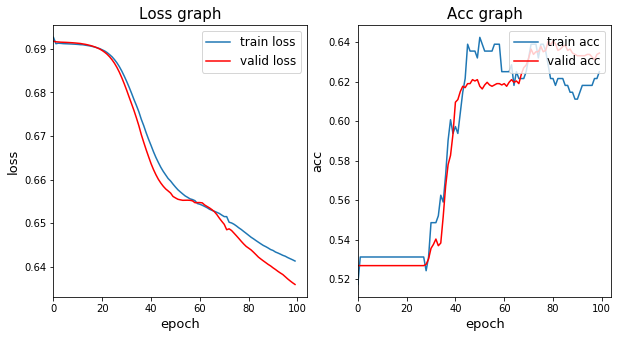

In [0]:
#Loss graph
%matplotlib inline

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.plot(train_history['loss'].tolist(), label='train loss')
ax.plot(valid_history['loss'].tolist(), label='valid loss', color='Red')

#ax.plot( range(val_freq, len(train_history)+val_freq, val_freq), valid_history['loss'], label='valid loss', marker='o', color='Red')
#ax.axis([0, len(train_history), 0, 1.0])
plt.xlim(0,None)
plt.legend(fontsize=12, loc='upper right')
plt.title('Loss graph', fontsize=15)
plt.xlabel('epoch', fontsize=13)
plt.ylabel('loss', fontsize=13)

plt.savefig(os.path.join(save_path, model_name, 'loss_graph.png'))

ax = fig.add_subplot(1,2,2)
ax.plot(train_history['acc'].tolist(), label='train acc')
ax.plot(valid_history['acc'].tolist(), label='valid acc', color='Red')

#ax.plot( range(val_freq, len(train_history)+val_freq, val_freq), valid_history['loss'], label='valid loss', marker='o', color='Red')
#ax.axis([0, len(train_history), 0, 1.0])
plt.xlim(0,None)
plt.legend(fontsize=12, loc='upper right')
plt.title('Acc graph', fontsize=15)
plt.xlabel('epoch', fontsize=13)
plt.ylabel('acc', fontsize=13)


plt.savefig(os.path.join(save_path, model_name, 'acc_graph.png'))


In [0]:
bestepoch = int(np.argmin(valid_history['loss']))

/home/gin908/paper_ready/py_36_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


In [0]:
error = valid_history.loc[bestepoch,'loss']
print ("error: {}".format(error))

error: 0.6359750266357135


In [0]:
bestepoch=bestepoch
MC_dropout_model.load(os.path.join(save_path, model_name,str(bestepoch)+'.ckpt'))

INFO:tensorflow:Restoring parameters from /data2/gin/savedmodel/ICML(UCR-yoga)_CNN_MCdropout_0.001_16/99.ckpt
Model restored


### with confusion matrix

In [0]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig=plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
    plt.subplot(122)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.tight_layout()
    plt.show()

In [0]:
class_list = np.unique(y_train, return_counts=False, return_index=True)[0].astype(int)

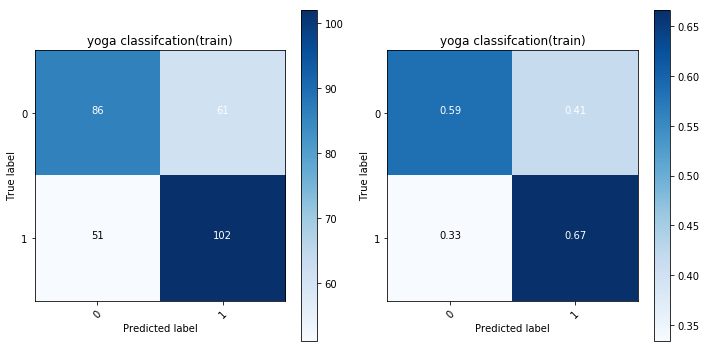

In [0]:
prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0,is_dropout=False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(trainY,axis=1)

plot_confusion_matrix(confusion_matrix(prediction,target),                      
    classes=class_list,
    title=fname+' classifcation(train)')

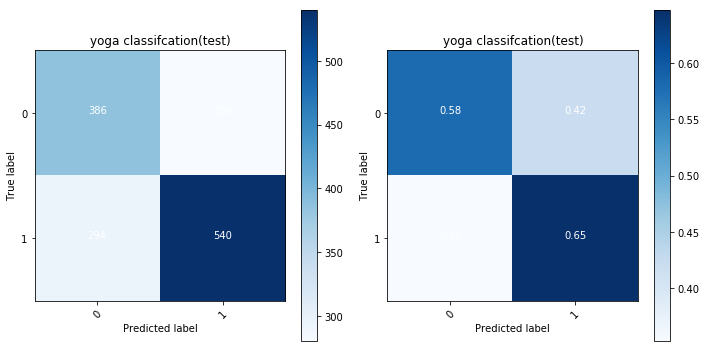

In [0]:
prediction = MC_dropout_model.predict(data=testX,keep_prob=1.0,is_dropout=False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(testY,axis=1)

plot_confusion_matrix(confusion_matrix(prediction,target),                      
    classes=class_list,
    title=fname+' classifcation(test)')

# 5. Trained 된 모델에서 Last Conv output Load하기(MC dropout적용안됨)

In [0]:
threshold = 0.2
focused_conv_channel = 11

In [0]:
#trainX를 인풋으로 넣었을 때, last conv layer 의 focused_conv_channel output 보기
last_conv_output1 = MC_dropout_model.get_last_conv_output(data=trainX,keep_prob=1.0,is_dropout=False)[:,0,:,focused_conv_channel]
last_conv_bool1 = last_conv_output1>threshold

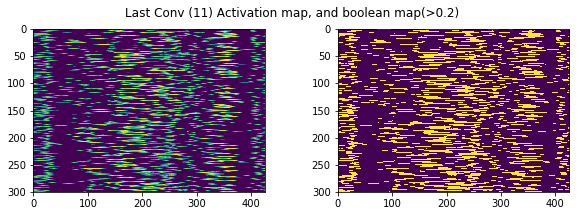

In [0]:
#각 한줄당 한 데이터에 대한 activation function 및 threshold를 넘은 부분
fig = plt.figure(figsize=(10,3))
fig.suptitle("Last Conv ({}) Activation map, and boolean map(>{})".format(focused_conv_channel, threshold))
ax = plt.subplot(1,2,1)
ax.imshow(last_conv_output1)

ax = plt.subplot(1,2,2)
ax.imshow(last_conv_bool1)

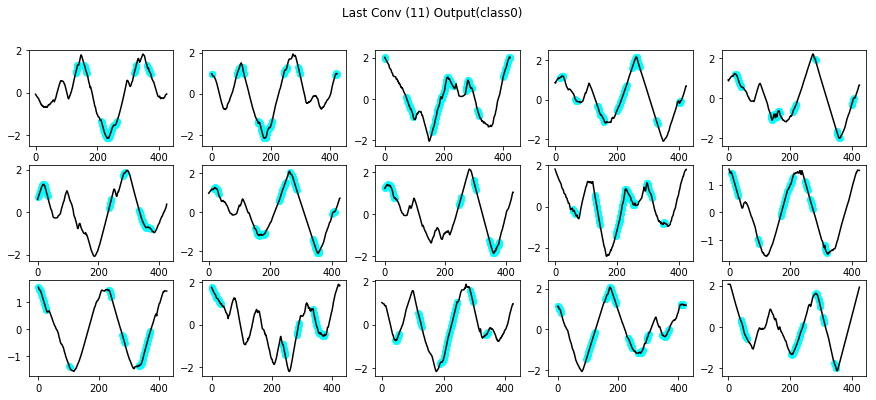

In [0]:
focused_label = 0

fig = plt.figure(figsize=(15,6))
fig.suptitle("Last Conv ({}) Output(class{}) ".format(focused_conv_channel,focused_label))
pattern =[]
for i,x in enumerate(trainX[np.argmax(trainY,axis=1) == focused_label]):
    ax = plt.subplot(3,5,i+1)
    data = x.reshape(-1,1)
    pattern_idx = [i for i, x in enumerate(last_conv_bool1[i]) if x]
    ax.plot(data,color='black')
    if pattern_idx:
        ax.scatter(pattern_idx, data[pattern_idx],color = "cyan")
    if i==14:
        break

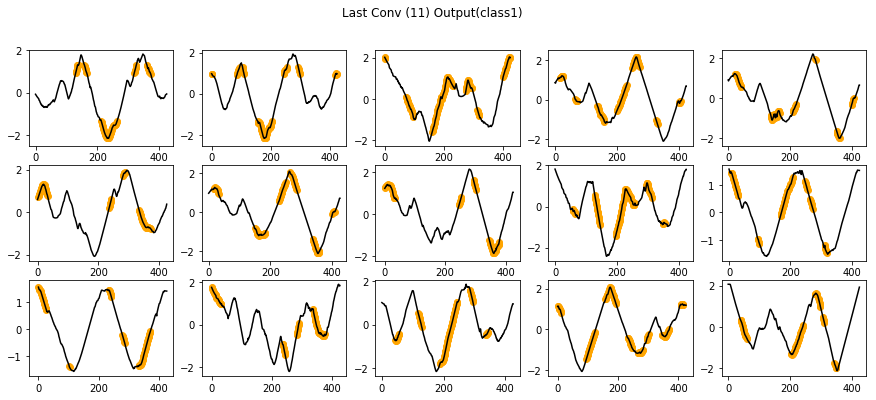

In [0]:
focused_label=1

fig = plt.figure(figsize=(15,6))
fig.suptitle("Last Conv ({}) Output(class{}) ".format(focused_conv_channel,focused_label))
pattern =[]
for i,x in enumerate(trainX[np.argmax(trainY,axis=1) == focused_label]):
    ax = plt.subplot(3,5,i+1)
    data = x.reshape(-1,1)
    pattern_idx = [i for i, x in enumerate(last_conv_bool1[i]) if x]
    ax.plot(data,color='black')
    if pattern_idx:
        ax.scatter(pattern_idx, data[pattern_idx],color = "orange")
    if i==14:
        break

# MC dropout을 적용한 패턴

In [0]:
#trainX를 인풋으로 넣었을 때, last conv layer 의 focused_conv_channel output 보기
last_conv_output1 = MC_dropout_model.get_last_conv_output(data=trainX,keep_prob=0.5,is_dropout=True)[:,0,:,focused_conv_channel]
last_conv_bool1 = last_conv_output1>threshold

In [0]:
last_conv_output1

array([[0.        , 0.        , 0.        , ..., 0.00808294, 0.        ,
        0.        ],
       [0.39092183, 0.29796994, 0.1399527 , ..., 0.3012198 , 0.20568377,
        0.0954373 ],
       [0.34940237, 0.3399358 , 0.33138216, ..., 0.35479814, 0.4133342 ,
        0.24737439],
       ...,
       [0.36255714, 0.38245106, 0.51736665, ..., 0.        , 0.2379351 ,
        0.16842574],
       [0.0719794 , 0.0810767 , 0.        , ..., 0.22331256, 0.06603651,
        0.13294064],
       [0.132565  , 0.20470376, 0.30253452, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

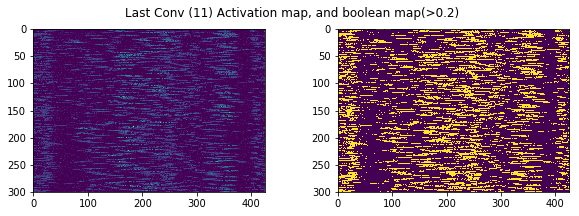

In [0]:
#각 한줄당 한 데이터에 대한 activation function 및 threshold를 넘은 부분
fig = plt.figure(figsize=(10,3))
fig.suptitle("Last Conv ({}) Activation map, and boolean map(>{})".format(focused_conv_channel, threshold))
ax = plt.subplot(1,2,1)
ax.imshow(last_conv_output1)

ax = plt.subplot(1,2,2)
ax.imshow(last_conv_bool1)

밑에 처럼 각 데이터에 대해서B번의 드랍아웃 한결과를 다 저장하면 될듯.

In [0]:
# prediction 시에는 MC dropout 을 적용
# keep_prob = 0.5(survive 확률) , dropout_bool=True

#각 데이터 마다 MC dropout 을 B 번 적용한다면, B 개의 서로 다른 model structure를 거치며 나타난 last conv output을 각 노드마다 모두 저장해놓음

#데이터가 N 개이고, MC dropout 횟수가 B번이라면, 총 N*B개의 패턴이 저장됨
#pattern_idx 에는 각 인풋마다 B번의 MC dropout했을 때, highlight되는 데이터의 인덱스를 저장

pattern_idx = []
B = 2

for X in trainX:
    X = np.expand_dims(X,0) # (height,width,channel) --> (1,height,width,channel)
    # 한 데이터에 대해서 B 번의 dropout을 적용
    for i in range(0,B):
        last_conv_output = MC_dropout_model.get_last_conv_output(data=X,keep_prob=0.5,is_dropout=True)[:,0,:,focused_conv_channel]
        last_conv_bool = last_conv_output1>threshold
        pattern_idx.append([i for i, x in enumerate(last_conv_bool[0]) if x])

# 6. pattern 저장해 놓은 것을 clustering 해서 라벨 붙혀주기?

클래스마다 같은 unit이어도 다른 패턴을 잡을까?

# 7. 각 노드당 pattern의 entropy 계산하여 uncertainty 계산?

# 8. uncertainty 가 특정 threshold보다 낮을 경우, pattern과 unit 매칭